In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re
from statannot import add_stat_annotation

In [2]:
PX_SIZE_UM = 1.6

In [28]:
def load_dataset(csv_path='stats.csv', data_path='/Volumes/Multicell/Sebastien/mESC_aggregates/SUMO/Cell_number/14022020_SUMO-number/D*/*stats.csv'):
    if os.path.exists(csv_path):
        dfs_all = pd.read_csv(csv_path, index_col=0)
        print('Loaded `stats.csv`')
    else:
        print('Loading raw data')
        paths = sorted(glob(data_path))
        assert (lp := len(paths)), 'Data not found'
        print(f'Found {lp} datasets')
        print([os.path.basename(p) for p in paths])
        
        r = re.compile(r'.*/(.*)-D(\d)_stats.csv')
        labels = [r.findall(p)[0] for p in paths]
        print(f'Labels: {labels}')
        
        dfs = []
        for path, l in zip(paths, labels):
            try:
                df = pd.read_csv(path, index_col=0)
                df['day'] = l[1]
                df['chip'] = l[0]
                dfs.append(df)
            except UnicodeDecodeError:
                print(f'bad file {path}')
        dfs_all = pd.concat(dfs)
        print(f'concatenate {lp} datasets')
        dfs_all['major_axis_length_um'] = dfs_all.major_axis_length * PX_SIZE_UM
        dfs_all.to_csv(csv_path)
        print(f'Saved to {csv_path}')
        
    return dfs_all


In [29]:
dfs_all = load_dataset(csv_path='Time_evolution_size_stats.csv', data_path='/home/aaristov/Multicell/Sebastien/mESC_aggregates/Time_evolution_size/*_stats.csv')

Loading raw data
Found 8 datasets
['Chip-D1_stats.csv', 'Chip-D2_stats.csv', 'Chip-D3_stats.csv', 'Chip-D4_stats.csv', 'Well-D1_stats.csv', 'Well-D2_stats.csv', 'Well-D3_stats.csv', 'Well-D4_stats.csv']
Labels: [('Chip', '1'), ('Chip', '2'), ('Chip', '3'), ('Chip', '4'), ('Well', '1'), ('Well', '2'), ('Well', '3'), ('Well', '4')]
concatenate 8 datasets
Saved to Time_evolution_size_stats.csv


In [30]:
dfs_all.index = dfs_all.chip

In [31]:
containers = dfs_all.chip.unique()
containers

array(['Chip', 'Well'], dtype=object)

In [32]:
days = dfs_all.day.unique()
days

array(['1', '2', '3', '4'], dtype=object)

In [33]:
def plot_days(dfs_all, x='day', y=['eccentricity', 'major_axis_length_um'], figsize=(10,4)):
    for day in dfs_all.day.unique():
        print(f'day {day}')
        fig, ax = plt.subplots(ncols=len(y), figsize=figsize)
        df = dfs_all[dfs_all.day == day]
        
        for _ax, _y in zip(ax, y):
            sns.swarmplot(data=df, x=x, y=_y, ax=_ax, size=3)
            sns.boxplot(data=df, x=x, y=_y, boxprops=dict(alpha=.3), ax=_ax)
            ax[0].set_title(f'{_y}: Day {day}')

        #     stats_ecc = add_stat_annotation(data=df, x='cell_number', y='eccentricity', ax=ax[0], **test_params_days)


        plt.tight_layout()
        plt.show()

day 1


day 2


day 3


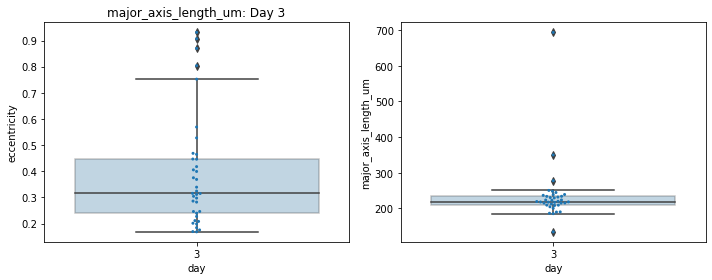

day 4


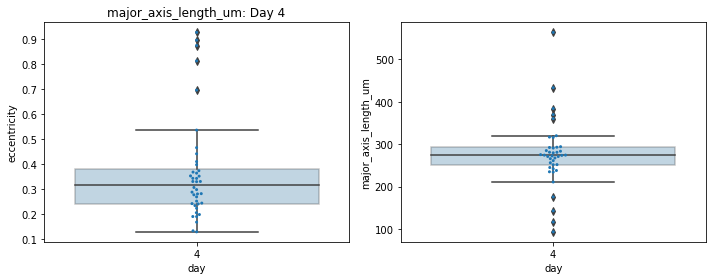

In [34]:
plot_days(dfs_all)

In [65]:
def plot_cond(dfs_all, cond='chip', x='day', y=['eccentricity', 'major_axis_length_um'], figsize=(10,4)):
    for cell_num in dfs_all[cond].unique():
        print(f'cond {cell_num}')
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        for _ax, _y in zip(ax, y):
            df = dfs_all[dfs_all[cond] == cell_num]
            sns.swarmplot(data=df, x=x, y=_y, ax=_ax, size=3)
            sns.boxplot(data=df, x=x, y=_y, boxprops=dict(alpha=.3), ax=_ax)
            _ax.set_title(f'{_y} `{cell_num}`')

        plt.tight_layout()
        plt.show()

cond Chip


cond Well


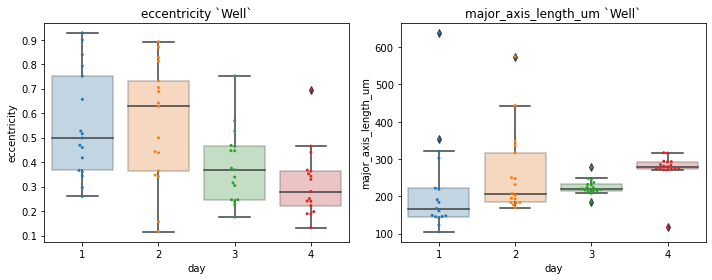

In [67]:
plot_cond(dfs_all)

In [46]:
plot_cond(dfs_good)

cond Chip


cond Well


In [68]:
dfs_good = dfs_all.query('eccentricity < 0.5').query('major_axis_length_um < 300')

In [71]:
test_params_days = dict(test='Mann-Whitney', text_format='star', loc='inside', verbose=1,
                                    box_pairs=[(('1','Well'), ('1','Chip')),
                                              (('2','Well'), ('2','Chip')),
                                              (('3','Well'), ('3','Chip')),
                                              (('4','Well'), ('4','Chip')),
                                              ]
                  )

In [72]:
def plot_all(dfs_all, cond='chip', x='day', y=['eccentricity', 'major_axis_length_um'], figsize=(10,4)):
    fig, ax = plt.subplots(1, len(y), figsize=(12,4), facecolor='w', dpi=150)
    
    for _ax, _y in zip(ax, y):
        sns.swarmplot(data=dfs_all, x=x, y=_y, hue=cond, ax=_ax, size=5, dodge=True)
        sns.boxplot(data=dfs_all, x=x, y=_y, hue=cond, boxprops=dict(alpha=.3), ax=_ax, dodge=True)
        _ax.set_title(f'{_y}')
    
    stats_ecc = add_stat_annotation(data=dfs_all, x=x, y=y[1], hue=cond, ax=ax[1], **test_params_days)
    
    plt.tight_layout()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_Chip v.s. 2_Well: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.020e-03 U_stat=1.030e+02
1_Chip v.s. 1_Well: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.420e-02 U_stat=1.240e+02
3_Chip v.s. 3_Well: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.600e+01
4_Chip v.s. 4_Well: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.567e-04 U_stat=8.000e+00


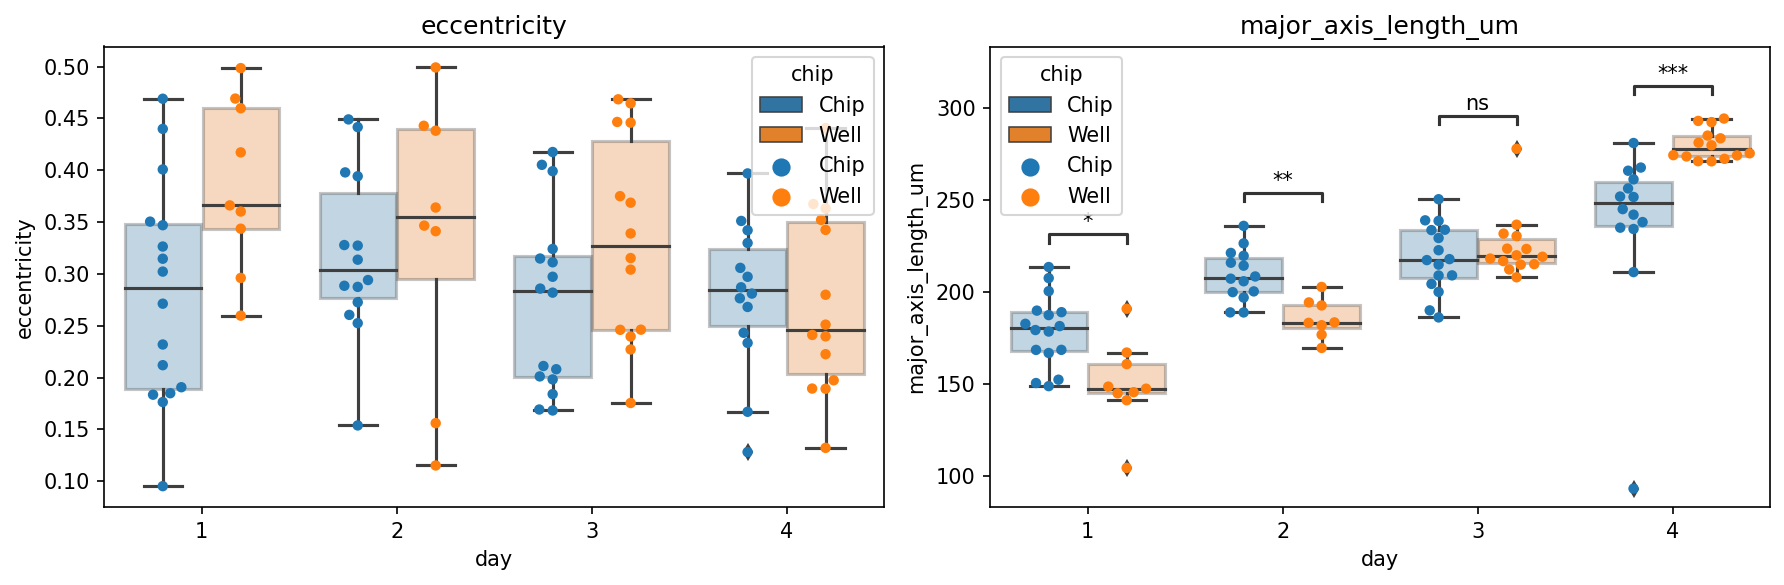

In [73]:
plot_all(dfs_good)

Text(0.5, 1.0, 'Major axis length, um')

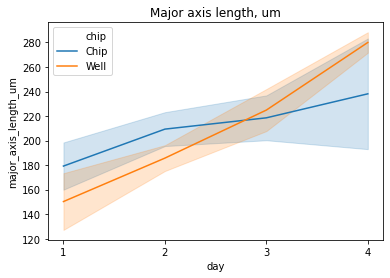

In [76]:
sns.lineplot(x='day', y='major_axis_length_um', hue='chip', data=dfs_good, ci='sd', markers=3)
plt.title('Major axis length, um')

Text(0.5, 1.0, 'Eccentricity')

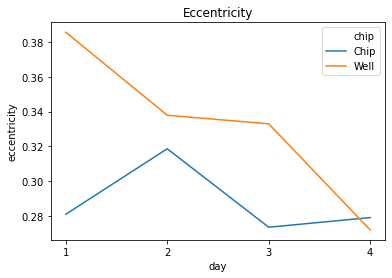

In [50]:
sns.lineplot(x='day', y='eccentricity', hue='chip',data=dfs_good, ci=None)
plt.title('Eccentricity')